In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
from utils import WindowGenerator

In [3]:
dataframe = pd.read_csv("Google Finance.csv")
dataframe.head()

,Date,Close
0,02/01/2023 16:56:00,"14,3"
1,03/01/2023 16:56:00,"14,57"
2,04/01/2023 16:56:00,"14,97"
3,05/01/2023 16:56:00,"14,8"
4,06/01/2023 16:56:00,"14,55"


# Tratamento de Dados

## String para Decimal

Os valores numéricos estão representados como strings. É preciso convertê-los.

In [4]:
dataframe['Close'] = dataframe['Close'].str.replace(',', '.')
dataframe['Close'] = pd.to_numeric(dataframe['Close'])

## Visualizar dados

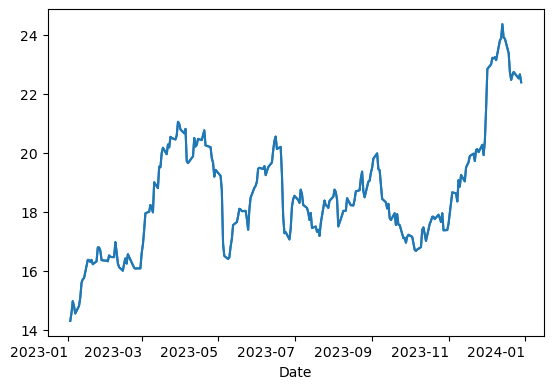

In [5]:
date_time = pd.to_datetime(dataframe.pop('Date'), format='%d/%m/%Y %H:%M:%S')

plot_features = dataframe['Close']
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = dataframe['Close'][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## Filtros

Os filtros a seguir não se aplicam ao projeto atual devido ao dataset utilizado, porém podem ser interessantes posteriormente.

In [6]:
# Filtrar colunas com mais de 90% de elementos nulos

# dataframe = dataframe[dataframe.columns[dataframe.isnull().mean() < 0.90]]

In [7]:
# Tratando NaN's

# dataframe = dataframe.interpolate()
# dataframe = dataframe.fillna(method='bfill')

# Tratamento para a Rede Neural

## Criando entradas e saídas de treino

As entradas são os 60 valores anteriores do preço da ação. A saída é o valor seguinte.

A seguir, também serão divididos os datasets de treino e de avaliação. Aprox. 70% dos dados serão
usados no treino, 20% na avaliação, e 10% no teste.

É importante notar também que a divisão foi feita seguindo a ordem dos dados no arquivo (os 70%
primeiros são para treino, os 20% seguintes para avaliação, e os 10% finais para teste).
Pode ser interessante mudar isso.

In [8]:
dataset = dataframe.iloc[:, 0].values

# Separação entre treino e avaliação

train_df = dataframe.iloc[0:int(dataset.shape[0] * 0.7), :]
val_df = dataframe.iloc[int(dataset.shape[0] * 0.7):int(dataset.shape[0] * 0.9), :]
test_df = dataframe.iloc[int(dataset.shape[0] * 0.9):, :]

In [9]:
# Variáveis para o modelo

input_size = 60

In [10]:
w1 = WindowGenerator(input_width=input_size, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Close'])

## Visualização

### Exemplo

Primeiro, foi criado um exemplo para visualização, contendo 3 exemplos de janela
a serem plotadas (example_window).

In [11]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[40:40+w1.total_window_size]),
                           np.array(train_df[80:80+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

# IMPORTANTE! O atributo example deve ser definido antes de usar o método plot

w1.example = example_inputs, example_labels

All shapes are: (batch, time, features)
Window shape: (3, 61, 1)
Inputs shape: (3, 60, 1)
Labels shape: (3, 1, 1)


Então, foi criada a função plot, depois definida como método de WindowGenerator.

In [12]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

WindowGenerator.plot = plot

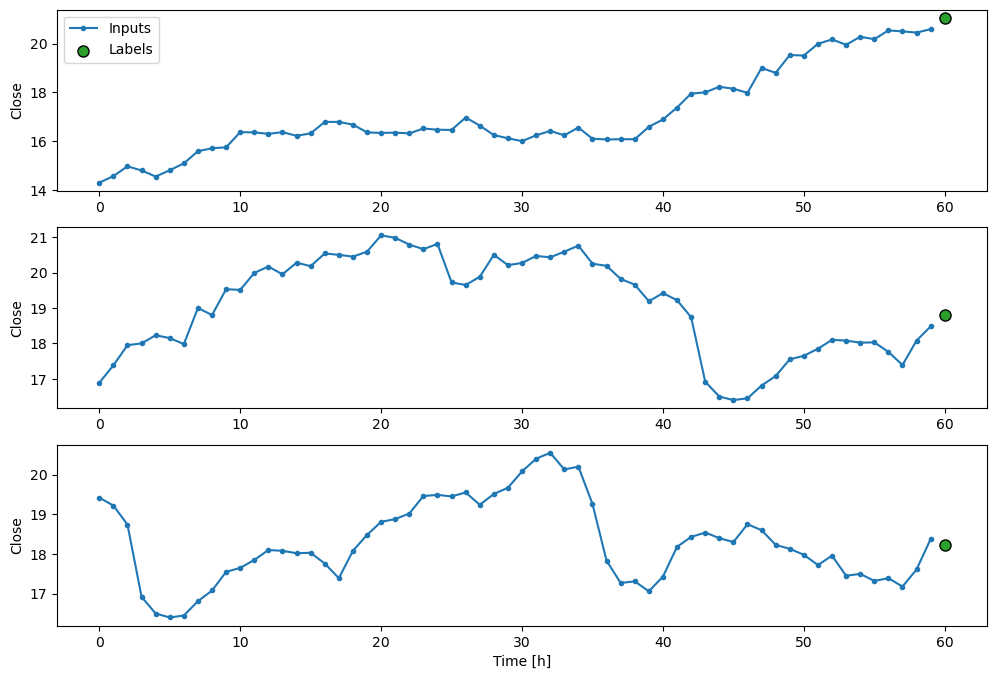

In [13]:
w1.plot()

# Baseline

Para comparação com modelos mais complicados.

A baseline desse caso será um modelo que retorna a temperatura atual como a previsão.

In [33]:
# Modelo

class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


# Single Step Window: a janela para o caso é de entrada única
    
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['Close'])

example_window_baseline = tf.stack([np.array(train_df[0:2]),
                           np.array(train_df[40:42]),
                           np.array(train_df[80:82])])

single_step_window.example = single_step_window.split_window(example_window_baseline)

# Auxiliar: column_indices

column_indices = {name: i for i, name in enumerate(dataframe.columns)}

1/1 [==============================] - 0s 48ms/step - loss: 0.2212


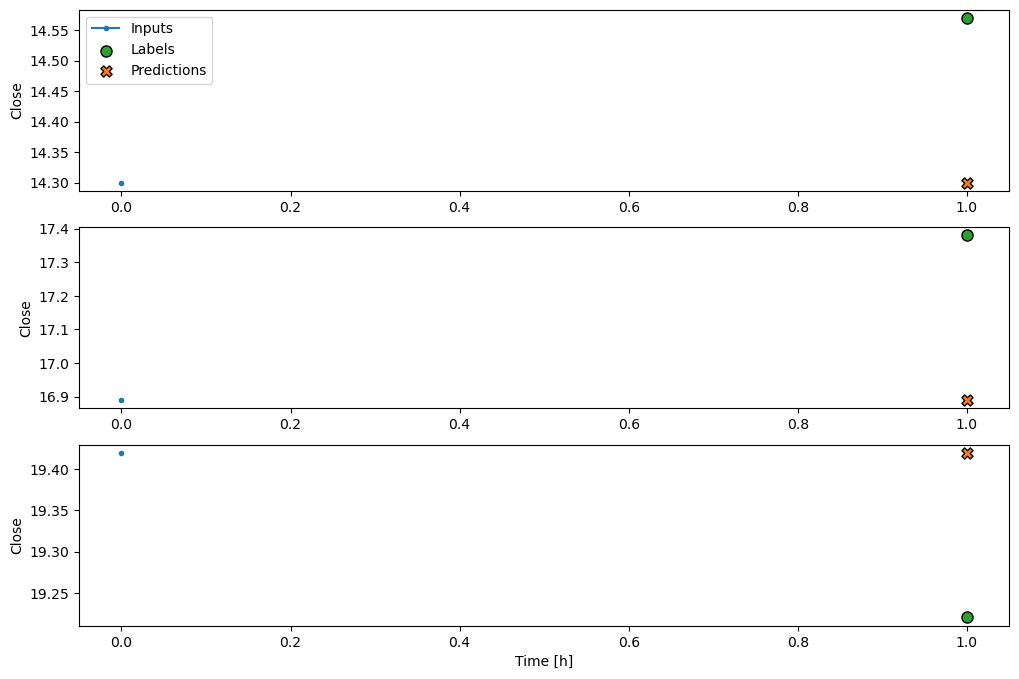

In [34]:
baseline = Baseline(label_index=column_indices['Close'])

baseline.compile(loss='mean_squared_error')

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test)

single_step_window.plot(baseline)

# Rede Neural

Foi implementada uma RNN, adequada para predição de séries temporais.

In [36]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

A próxima célula captura o output (longo) para a variável history

In [37]:
%%capture history
model.fit(w1.train, validation_data=w1.val, epochs=150)

ValueError: Expected input data to be non-empty.

In [23]:
# print(history)

Analisando o histórico (history), é possível avaliar se a rede estagnou após
um determinado número de epochs.

Primeiro modelo (4 LSTM-Dropouts, 1 Dense): estagnou após ~100 epochs.

# Avaliando modelo

In [18]:
performance['LSTM'] = model.evaluate(w1.test)

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

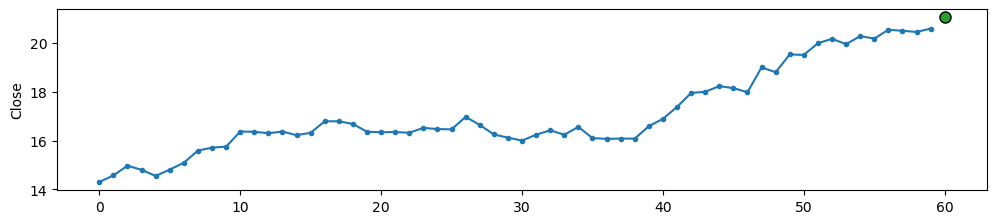

In [35]:
w1.plot(model)

TODOs:
- Considerar que existem dias faltantes na entrada
- Revisar divisão de dados entre treino, avaliação e teste
- Melhorar modelo
- Revisar epochs e batch size
- Implementação do método plot